# ML Pipeline Preparation


### Import libraries and load data


In [1]:
import numpy as np
import pandas as pd
from sqlalchemy import create_engine

from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV, train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.multioutput import MultiOutputClassifier
# from sklearn.base import BaseEstimator, TransformerMixin

import re
import nltk
nltk.download(['punkt', 'wordnet', 'stopwords', 'averaged_perceptron_tagger', 'maxent_ne_chunker', 'words'])
from nltk.corpus import stopwords
from nltk import pos_tag, ne_chunk
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer

# visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(); color='rebeccapurple'
%matplotlib inline  

# display settings
pd.set_option('max_colwidth', -1)
pd.set_option('display.max_columns', None)  

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping chunkers/maxent_ne_chunker.zip.
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


In [2]:
# load data from database with `read_sql_table`
engine = create_engine('sqlite:///DisasterResponse.db')
df = pd.read_sql_table('messages', engine)

## Have a look at data structure

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26180 entries, 0 to 26179
Data columns (total 40 columns):
id                        26180 non-null int64
message                   26180 non-null object
original                  10153 non-null object
genre                     26180 non-null object
related                   26180 non-null int64
request                   26180 non-null int64
offer                     26180 non-null int64
aid_related               26180 non-null int64
medical_help              26180 non-null int64
medical_products          26180 non-null int64
search_and_rescue         26180 non-null int64
security                  26180 non-null int64
military                  26180 non-null int64
child_alone               26180 non-null int64
water                     26180 non-null int64
food                      26180 non-null int64
shelter                   26180 non-null int64
clothing                  26180 non-null int64
money                     26180 non-null i

In [4]:
df.head()

,id,message,original,genre,related,request,offer,aid_related,medical_help,medical_products,search_and_rescue,security,military,child_alone,water,food,shelter,clothing,money,missing_people,refugees,death,other_aid,infrastructure_related,transport,buildings,electricity,tools,hospitals,shops,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
0,2,Weather update - a cold front from Cuba that could pass over Haiti,Un front froid se retrouve sur Cuba ce matin. Il pourrait traverser Haiti demain. Des averses de pluie isolee sont encore prevues sur notre region ce soi,direct,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,7,Is the Hurricane over or is it not over,Cyclone nan fini osinon li pa fini,direct,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0
2,8,Looking for someone but no name,"Patnm, di Maryani relem pou li banm nouvel li ak timoun yo. Mesi se john jean depi Monben kwochi.",direct,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,9,UN reports Leogane 80-90 destroyed. Only Hospital St. Croix functioning. Needs supplies desperately.,UN reports Leogane 80-90 destroyed. Only Hospital St. Croix functioning. Needs supplies desperately.,direct,1,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,12,"says: west side of Haiti, rest of the country today and tonight",facade ouest d Haiti et le reste du pays aujourd hui et ce soir,direct,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### Explore target class distribution

For a stratified split into test and training sets, the target class distribution has to be known and understood

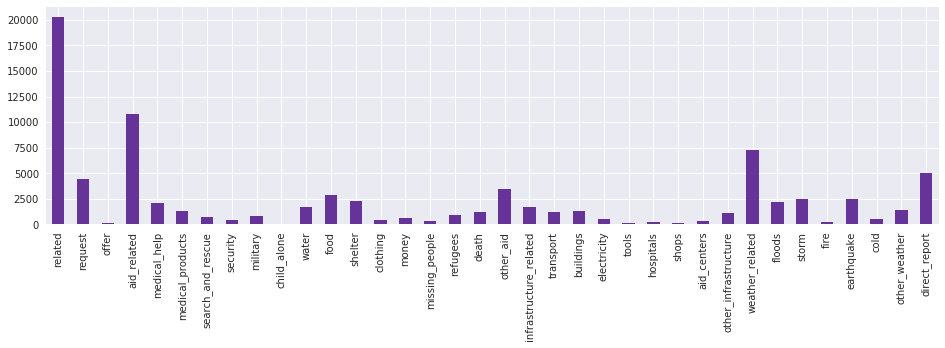

In [5]:
# check for general target class distribution
plt.figure(figsize=(16,4))
df.iloc[:,4:40].sum().plot.bar(color=color);

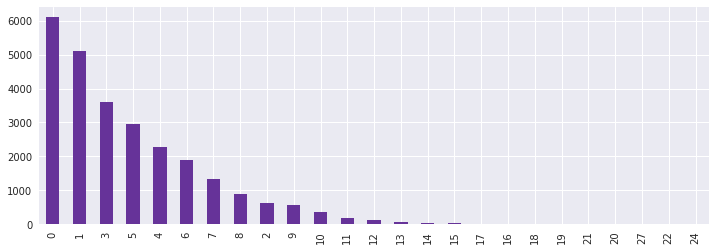

In [6]:
# check for distribution of different numbers of target categories per message

# create new column with total of active categories per message
df['total'] = df.iloc[:,4:40].sum(axis=1)
# plot the result
plt.figure(figsize=(12,4))
df['total'].value_counts().plot.bar(color=color);

In [7]:
# check for most frequent category counts per message
df['total'].value_counts().head()

0    6116
1    5115
3    3603
5    2950
4    2273
Name: total, dtype: int64

In [8]:
# check a sample of messages with 0 active categories
df.loc[(df['total'] == 0), ['message']].sample(5)

,message
1960,"My wife, my children, my brothers and sisters, in Canal Bois, in Gonaives,"
5807,I want to be enrolled in this program
18122,The TFG's legislative branch is the 550-seat Transitional Federal Parliament (TFP).
18748,"The offer relates to communication technology -- pre-Wimax and fiber optic cables -- and involves the use of a number of public resources, such as radio frequency."
16709,"Financial contributions from individuals, corporations and foundations are used to defray the cost of AmeriCares' programs."


In [9]:
# check a sample of messages with 1 active categories
df.loc[(df['total'] == 1), ['message']].sample(5)

,message
21468,Present conversion capability at just one gigawatt (representing 12 percent of Fukushima Daiichi output) falls far short of demand.
18639,"Pleased and full of admiration to see how quickly people have got back on their feet, rebuilt homes, planted their fields, and yet also saddened to see the wooden frames of locally built houses, standing forlornly with their mud walls now only beginning at eight feet up, just under the thatched roof."
18981,"As one of the Small Island Developing States, Dominica had to deal with the problem of the safe disposal of solid and liquid waste, which could result in marine pollution and coastal degradation."
21941,"Mercy Corps, operating with a grant from the U.S. Office of Foreign Disaster Assistance, made its very first subgrant to Sewalanka, enabling the organization to deliver more than 10,000 packets of sanitary pads to women displaced along the island nation's east coast."
24565,He developed symptoms on 7 November and died on 10 November from an undiagnosed cause.


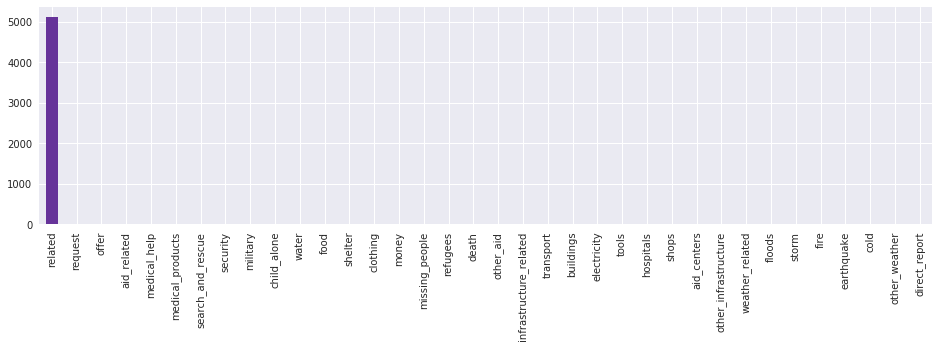

In [10]:
# check which categories are active for plots with category count of 1
df_temp1 = df.loc[(df['total'] == 1)]
# plot the result
plt.figure(figsize=(16,4))
df_temp1.iloc[:,4:40].sum().plot.bar(color=color);

__Observations__
- 6'116 messages are not distaster related (and are logically not associated to a category)
- 5'115 messages are disaster related but are not associated to a category
- 14'949 remaining messages are related and associated to 2-26 different categories each
- these seem to be grouped again into 3 main categories aid_related, infrastructure_related, weather_related
- messages with more than approx. 10 categories each are quite rare and seem to be kind of 'outliers'

__Decision__

Data will be split into test and training set with stratified sampling to preserve the distribution of number of categories in both sets. This is important to make sure that especially the proportions of non-related messages (0 active categories) and related but non-categorized messages (1 active category = 'related') will be the same in both sets.

## Split data into training and test sets (with stratified sampling)

In [11]:
# for StratifiedShuffleSlpit to work properly all values > 10 in ['total'] column will be set to 11.
df['total'] = np.where((df['total'] >10), 11, df['total'])

In [12]:
# create testset with stratified sampling according to the category count per message
split = StratifiedShuffleSplit(n_splits = 1, test_size = 0.2, random_state = 111)
for train_index, test_index in split.split(df, df['total']):
    train = df.loc[train_index]
    test = df.loc[test_index]
    
# safety-check
assert len(test) == round(len(df) * 0.2), 'split got messed up'
assert (round(df['related'].sum() / len(df),3)) == (round(train['related'].sum() / len(train),3)), 'not properly stratisfied'

In [13]:
# make a copy of the train set for some further exlporation
eda = train.copy()

In [14]:
# remove 'total' column from train and test sets
for set_ in (train, test):
    set_.drop('total', axis=1, inplace=True)
    
# safety-check
assert len(test.columns) == 40

## Some further EDA on training set

Further exploration is performed on training only set to prevent 'data snooping bias'.

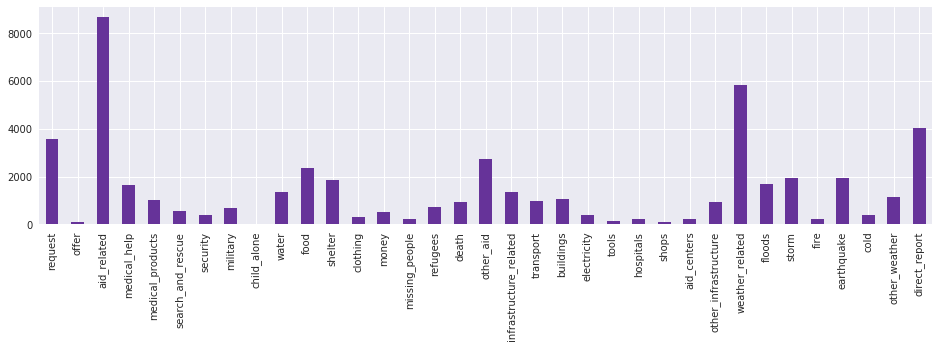

In [15]:
# distribution of the categories for related and categorized messages only (excluding category 'related')
eda_categorized = eda.loc[(eda['total'] > 1)]
# plot the result
plt.figure(figsize=(16,4))
eda.iloc[:,5:40].sum().plot.bar(color=color);

__Observation:__  Categories are imbalanced, this will have to be taken into account for model training

### Check 'outlier messages' > 10 active categories

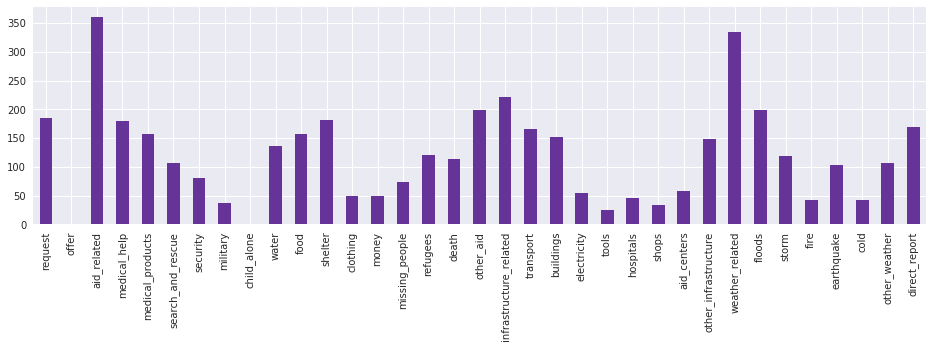

In [16]:
# check if 'outlier messages' with more than 10 categories have some special distribution
eda_outliers = eda.loc[(eda['total'] > 10)]
# plot the result
plt.figure(figsize=(16,4))
eda_outliers.iloc[:,5:40].sum().plot.bar(color=color);

In [17]:
## print number / proportion of those messages
print("Messages with > 10 active categories: {} ({}% of total)" \
      .format(len(eda_outliers), round(100*(len(eda_outliers)/len(eda)),2)))

Messages with > 10 active categories: 360 (1.72% of total)


In [19]:
# look at sample of messages with more than 20 active categories
eda.loc[(eda['total'] > 10)][['message']].sample(5)

message
727    need some help please we ar at carrefour pernier please verify location. ..                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      

In [20]:
# check genre of these outliers
eda_outliers['genre'].value_counts()

news      199
direct    139
social    22 
Name: genre, dtype: int64

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


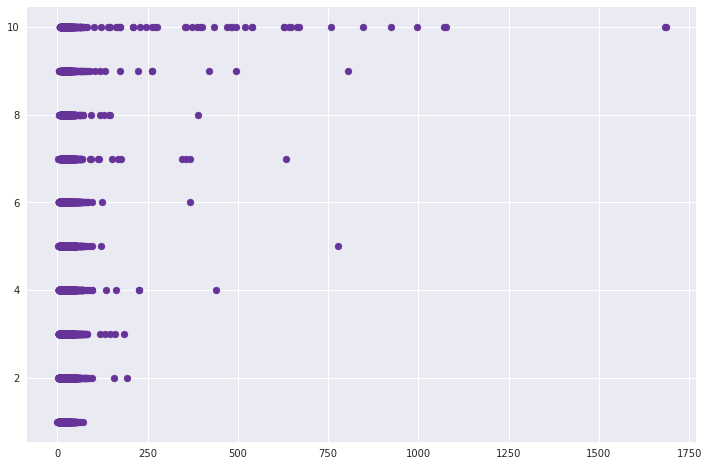

In [21]:
# check for correlation between message length (in words) and number of active categories

# generate necessary columns
eda_categorized['n_categories'] = eda_categorized['total'] -1 # remove 'related' from count
eda_categorized['message_length'] = eda_categorized['message'].apply(lambda x : len(x.split())) # get message length

# plot the results
plt.figure(figsize=(12,8))
plt.scatter(eda_categorized['message_length'], eda_categorized['n_categories'], color=color);

In [22]:
# print pearson's r for the two columns
eda_categorized[['n_categories', 'message_length']].corr() 

,n_categories,message_length
n_categories,1.000000,0.177893
message_length,0.177893,1.000000


In [23]:
# check mean length of different groups of messages
print('all messages   {:6f}'.format(eda_categorized['total'].mean()))
print('all related messages   {:6f}'.format(eda.loc[eda['related'] == 1]['total'].mean()))
print('all aid related messages   {:6f}'.format(eda.loc[eda['aid_related'] == 1]['total'].mean()))
print('all infrastructure related messages   {:6f}'.format(eda.loc[eda['infrastructure_related'] == 1]['total'].mean()))
print('all weather related messages   {:6f}'.format(eda.loc[eda['weather_related'] == 1]['total'].mean()))

all messages   5.172004
all related messages   4.129097
all aid related messages   5.827702
all infrastructure related messages   7.821637
all weather related messages   5.906287


__Observations__: The Distribution of the 'oultier messages' is not very different from the total distribution and the correlation between message length and number of categories is positive but weak. It seems, that the long messages are mostly reports, probably by professional staff (NGOs, Journalists etc.) and not calls for help.

### Check influence of column 'genre'

In [24]:
# check proportion of related messages per genre
print('overall   {:6f}'.format(eda['related'].mean()))
eda.groupby('genre') ['related'].mean()

overall   0.773825


genre
direct    0.692370
news      0.820057
social    0.889126
Name: related, dtype: float64

In [25]:
# check mean number of categories for related messages per genre
print('overall   {:6f}'.format(eda_categorized['total'].mean()))
eda_categorized.groupby('genre') ['total'].mean()

overall   5.172004


genre
direct    5.458752
news      5.060497
social    4.778875
Name: total, dtype: float64

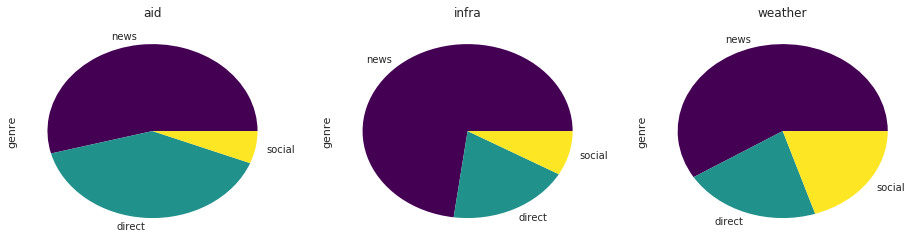

In [26]:
# check influence of main categories on genre (or vice versa)

# create dataframes for plotting
eda_aid = eda.loc[eda['aid_related'] == 1]
eda_infra = eda.loc[eda['infrastructure_related'] == 1]
eda_weather = eda.loc[eda['weather_related'] == 1]
# plot the results
plt.figure(figsize=(16,4))
i = 0
for df, label in [(eda_aid, 'aid'), (eda_infra, 'infra'), (eda_weather, 'weather')]:
    i += 1
    plt.subplot(1,3, i)
    plt.title(label)
    df['genre'].value_counts().plot.pie(cmap='viridis');

__Observations__
- There are significantly less disaster related messages in genre direct than in genres news and especially social
- the mean number of categories per message is around 5 for all genres, interesingly it is going down the more messages are related.
- The proportions of the different genres differ within the main categories.

__Conclusion / Decision:__ 
- The information in `genre` could most probably help to train a classifier, but for the purpose of this project (web app to classify plain text inputs) it won't help, so it will be dropped.
- Further the `id` and `original`columns will be dropped too.

## Split into features an target variables

In [39]:
X_train = train['message'].values
y_train = train.iloc[:, 4:40].values

X_test = test['message'].values
y_test = test.iloc[:, 4:40].values

In [28]:
#check
X_train[:2]

array([ "To determine possible evolution of the eruptive crisis of the Nyiragongo, it's necessary to improve the monitoring of the volcano, in particularly to add seismometers and to install tiltmeters to measure the ground deformation around the volcano.",
       'Over 25 people in line at Starbucks . People need coffee as much as they need food and gas post #Sandy ( @Starbucks ) http : //t.co/T7G3fBJg'], dtype=object)

In [29]:
#check
y_train[:2]

array([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0],
       [1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

### 2. Write a tokenization function to process your text data

In [35]:
def tokenize_text(message):

    lemmatizer = WordNetLemmatizer()
    stop_words = stopwords.words('english')
    
    # normalize case and remove punctuation
    message = re.sub(r"[^a-zA-Z0-9]", " ", message.lower())
    # tokenize text
    tokens = word_tokenize(message)
    # lemmatize and remove stop words
    tokens = [lemmatizer.lemmatize(word.strip()) for word in tokens if word not in stop_words]
    # add part-of-speech tags
    tokens = pos_tag(tokens)
    
    return tokens

In [36]:
for message in X_train[:2]:
    tokens = tokenize_text(message)
    print(message)
    print(tokens, '\n')

To determine possible evolution of the eruptive crisis of the Nyiragongo, it's necessary to improve the monitoring of the volcano, in particularly to add seismometers and to install tiltmeters to measure the ground deformation around the volcano.
[('determine', 'NN'), ('possible', 'JJ'), ('evolution', 'NN'), ('eruptive', 'JJ'), ('crisis', 'NN'), ('nyiragongo', 'NN'), ('necessary', 'JJ'), ('improve', 'VB'), ('monitoring', 'NN'), ('volcano', 'NN'), ('particularly', 'RB'), ('add', 'JJ'), ('seismometers', 'NNS'), ('install', 'VBP'), ('tiltmeters', 'NNS'), ('measure', 'VBP'), ('ground', 'NN'), ('deformation', 'NN'), ('around', 'IN'), ('volcano', 'NN')] 

Over 25 people in line at Starbucks . People need coffee as much as they need food and gas post #Sandy ( @Starbucks ) http : //t.co/T7G3fBJg
[('25', 'CD'), ('people', 'NNS'), ('line', 'NN'), ('starbucks', 'VBZ'), ('people', 'NNS'), ('need', 'VBP'), ('coffee', 'NN'), ('much', 'JJ'), ('need', 'NN'), ('food', 'NN'), ('gas', 'NN'), ('post', 'NN

### 3. Build a machine learning pipeline
Use sk-learn's [MultiOutputClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.multioutput.MultiOutputClassifier.html) ([example here](https://scikit-learn.org/stable/modules/multiclass.html#multioutput-classification))

In [41]:
# define the classifier, wrapped in MultiOutputClassifier
clf = RandomForestClassifier(n_estimators=100, random_state=1)

# build the pipeline
pipe = Pipeline([
    ('vect', CountVectorizer(tokenizer=tokenize_text)),
    ('tfidf', TfidfTransformer()),
    ('clf', MultiOutputClassifier(clf, n_jobs=-1, verbose=1)),
              ])

# train the pipeline
pipe.fit(X_train, y_train)

In [40]:
y_pred = pipe.predict(X_test)

### 5. Test your model
Report the f1 score, precision and recall for each output category of the dataset. You can do this by iterating through the columns and calling sklearn's `classification_report` on each.

In [55]:
category_list = train.iloc[:, 4:40].columns

for col in y_test.T:
    print(classification_report(y_test.T, y_pred.T, target_names=category_list))

ValueError: Unknown label type: (array([[1, 1, 1, ..., 1, 1, 1],
       [0, 0, 1, ..., 1, 0, 1],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [1, 0, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       [1, 0, 1, ..., 1, 0, 1]]), array([[1, 1, 1, ..., 1, 1, 1],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 1]]))

In [ ]:
def get_eval_metrics(actual, predicted, col_names):
    """Calculate evaluation metrics for ML model
    
    Args:
    actual: array. Array containing actual labels.
    predicted: array. Array containing predicted labels.
    col_names: list of strings. List containing names for each of the predicted fields.
       
    Returns:
    metrics_df: dataframe. Dataframe containing the accuracy, precision, recall 
    and f1 score for a given set of actual and predicted labels.
    """
    metrics = []
    
    # Calculate evaluation metrics for each set of labels
    for i in range(len(col_names)):
        accuracy = accuracy_score(actual[:, i], predicted[:, i])
        precision = precision_score(actual[:, i], predicted[:, i])
        recall = recall_score(actual[:, i], predicted[:, i])
        f1 = f1_score(actual[:, i], predicted[:, i])
        
        metrics.append([accuracy, precision, recall, f1])
    
    # Create dataframe containing metrics
    metrics = np.array(metrics)
    metrics_df = pd.DataFrame(data = metrics, index = col_names, columns = ['Accuracy', 'Precision', 'Recall', 'F1'])
      
    return metrics_df

In [ ]:
def evaluate_model(model, X_test, Y_test, category_names):

    

    # predict on test data

    y_pred = model.predict(X_test)

    

    accuracy = []



    y_testData = pd.DataFrame(Y_test)

    y_predData = pd.DataFrame(y_pred)



    for col in range(len(y_testData.columns)):

        accuracy.append(accuracy_score(y_testData[col],y_predData[col]))

 		

    target_colums = (category_names.iloc[:,4:].columns).tolist()

	

    acc_score = pd.DataFrame(accuracy,columns=['Accuracy_score'], index=target_colums)

	

    target_names = (category_names.iloc[:,4:].columns).tolist()

	

    output = classification_report(Y_test, y_pred, target_names=target_names)

	

    print("Accuracy for each category:\n")

    print(acc_score)

    

    print("\n\nPrecision,recall, f1-score and support for each category:\n")

    print(output)

### 6. Improve your model
Use grid search to find better parameters. 

In [ ]:
parameters = 

cv = 

### 7. Test your model
Show the accuracy, precision, and recall of the tuned model.  

Since this project focuses on code quality, process, and  pipelines, there is no minimum performance metric needed to pass. However, make sure to fine tune your models for accuracy, precision and recall to make your project stand out - especially for your portfolio!

### 8. Try improving your model further. Here are a few ideas:
* try other machine learning algorithms
* add other features besides the TF-IDF

### 9. Export your model as a pickle file

### 10. Use this notebook to complete `train.py`
Use the template file attached in the Resources folder to write a script that runs the steps above to create a database and export a model based on a new dataset specified by the user.

- to do: concatenate one hot encoded genre with text
- eventually length and total categories to